In [1]:
import random
import kwant
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import logging
import math
from tqdm import tqdm
import shutil
import tarfile
from matplotlib import cm

c:\Users\julie\anaconda3\envs\c3mp\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\julie\anaconda3\envs\c3mp\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


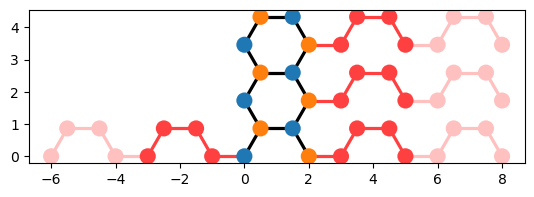

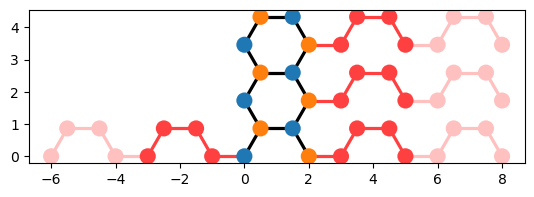

In [44]:
def make_system(
    scatter_width: int,
    scatter_length: int,
    leads_orientation: list,
    leads_up_shift: list,
    scatter_up_shift: int = 0,
    verbose: bool = False,
) -> tuple:
    """
    Creates a kwant system, made of a simple rectangular scattering region and two leads, one on each side.
    
    Parameters
    ----------
    * scatter_width (int): width of the scattering region, in layers.
    * scatter_length (int): length of the scattering region, in number of 'honeycomb' cells (ie. 3N layers).
    * lead_width (int): width of the leads, in layers.
    * lead_length (int): length of the leads, in number of 'honeycomb' cells (ie. 3N layers).
    * scatter_up_shift (int): number of layers to shift the scattering region up by.
    * left_lead_up_shift (int): number of layers to shift the left lead up by.
    * right_lead_up_shift (int): number of layers to shift the right lead up by.
    * verbose (bool): whether to print the system parameters or not.
    
    Returns
    -------
    * sys (kwant.builder.Builder): the scattering region.
    * left_lead (kwant.builder.Builder): the left lead.
    * right_lead (kwant.builder.Builder): the right lead.
    """

    if verbose: print("Building a system with the following parameters:")
    if verbose: print(f"Scatter region: {scatter_width:>2} layers wide & {scatter_length:>2} 'honeycomb' long (ie. {4*scatter_length:>2} layers long)")

    # Defining constants
    # ------------------

    SIN_60 = math.sin(math.pi / 3)
    GRAPHENE = kwant.lattice.general(
        [(0, math.sqrt(3)), (-3/2, -math.sqrt(3)/2)], # base vectors
        [(0,0), (1/2,math.sqrt(3)/2)], # initial atoms (in cartesian coordinates), one for each atom in the unit cell
        norbs = 1, # number of orbitals per site
    )
    POT = 0.0
    T = 1
    SCATTER_LENGTH = 3 * scatter_length
    LEAD_LENGTH = 3
    LEAD_WIDTH = 2
    SMALL = 1e-3

    # Defining the scattering region
    # ------------------------------

    def scatter_rect(pos):
        x, y = pos
        # y -= scatter_up_shift * SIN_60
        # is_inside_rectangle = ((0 < x + SMALL < SCATTER_LENGTH) and (0 < y + SMALL < scatter_width * SIN_60))
        is_inside_rectangle = ((0 < x + SMALL < SCATTER_LENGTH) and (scatter_up_shift * SIN_60 < y + SMALL < scatter_width * SIN_60 + scatter_up_shift * SIN_60))

        return is_inside_rectangle
    sys = kwant.Builder()
    sys[GRAPHENE.shape(scatter_rect, start=(0 if scatter_up_shift % 2 == 0 else 1/2, 0 * scatter_up_shift * SIN_60))] = POT
    sys[GRAPHENE.neighbors()] = -T

    # Defining the leads
    # ------------------

    leads = []

    for orientation, up_shift in zip(leads_orientation, leads_up_shift):

        if verbose: print(
            "Lead will be inside [{};{}]x[{};{}]" \
            .format(0, LEAD_LENGTH, up_shift * SIN_60, LEAD_WIDTH * SIN_60 + up_shift * SIN_60)
        )
        
        def lead_rect_left(pos):
            x, y = pos
            is_inside_rectangle = ((0 < x + SMALL < LEAD_LENGTH) and (up_shift * SIN_60 < y + SMALL < LEAD_WIDTH * SIN_60 + up_shift * SIN_60))
            return is_inside_rectangle

        def lead_rect_right(pos):
            x, y = pos
            is_inside_rectangle = ((0 < x + SMALL < LEAD_LENGTH) and (up_shift * SIN_60 < y + SMALL < LEAD_WIDTH * SIN_60 + up_shift * SIN_60))
            return is_inside_rectangle
        
        if orientation == 'l':
            sym = kwant.TranslationalSymmetry((LEAD_LENGTH, 0))
            lead = kwant.Builder(sym)
            lead[GRAPHENE.shape(lead_rect_left, start=(0 if up_shift % 2 == 0 else 1/2, up_shift * SIN_60))] = POT
            lead[GRAPHENE.neighbors()] = -T
            lead = lead.reversed()
        elif orientation == 'r':
            sym = kwant.TranslationalSymmetry((LEAD_LENGTH, 0))
            lead = kwant.Builder(sym)
            lead[GRAPHENE.shape(lead_rect_right, start=(0 if up_shift % 2 == 0 else 1/2, up_shift * SIN_60))] = POT
            lead[GRAPHENE.neighbors()] = -T
        else:
            raise ValueError(f"Unknown lead orientation: {orientation}")
        leads.append(lead)

    return sys, leads

lead_orientations = ['l', 'l', 'l', 'r', 'r', 'r']
lead_up_shifts = [0, 2, 4, 4, 2, 0]
indices = np.random.choice(np.arange(6), np.random.randint(1, 6), replace=False)

scatter, leads = make_system(
    scatter_width=5,
    scatter_length=1,
    scatter_up_shift=1,
    leads_orientation=[x for i, x in enumerate(lead_orientations) if i in indices],
    leads_up_shift=[x for i, x in enumerate(lead_up_shifts) if i in indices],
    verbose=False,
)

for lead in leads:
    scatter.attach_lead(lead)

scatter = scatter.finalized()

kwant.plot(scatter)

In [35]:
mylist = ["a", "b", "c"]
print(mylist[[1, 2]])

TypeError: list indices must be integers or slices, not list

In [2]:
def make_system(
    scatter_width: int,
    scatter_length: int,
    lead_width: int,
    lead_length: int = 1,
    scatter_up_shift: int = 0,
    left_lead_up_shift: int = 0,
    right_lead_up_shift: int = 0,
    verbose: bool = False,
) -> tuple:
    """
    Creates a kwant system, made of a simple rectangular scattering region and two leads, one on each side.
    
    Parameters
    ----------
    * scatter_width (int): width of the scattering region, in layers.
    * scatter_length (int): length of the scattering region, in number of 'honeycomb' cells (ie. 3N layers).
    * lead_width (int): width of the leads, in layers.
    * lead_length (int): length of the leads, in number of 'honeycomb' cells (ie. 3N layers).
    * scatter_up_shift (int): number of layers to shift the scattering region up by.
    * left_lead_up_shift (int): number of layers to shift the left lead up by.
    * right_lead_up_shift (int): number of layers to shift the right lead up by.
    * verbose (bool): whether to print the system parameters or not.
    
    Returns
    -------
    * sys (kwant.builder.Builder): the scattering region.
    * left_lead (kwant.builder.Builder): the left lead.
    * right_lead (kwant.builder.Builder): the right lead.
    """

    if verbose: print("Building a system with the following parameters:")
    if verbose: print(f"Scatter region: {scatter_width:>2} layers wide & {scatter_length:>2} 'honeycomb' long (ie. {4*scatter_length:>2} layers long)")
    if verbose: print(f"Lead region: {lead_width:>2} layers wide & {lead_length:>2} 'honeycomb' long (ie. {4*lead_length:>2} layers long)")

    # Defining constants
    # ------------------

    SIN_60 = math.sin(math.pi / 3)
    GRAPHENE = kwant.lattice.general(
        [(0, math.sqrt(3)), (-3/2, -math.sqrt(3)/2)], # base vectors
        [(0,0), (1/2,math.sqrt(3)/2)], # initial atoms (in cartesian coordinates), one for each atom in the unit cell
        norbs = 1, # number of orbitals per site
    )
    POT = 0.0
    T = 1
    SCATTER_LENGTH = 3 * scatter_length
    LEAD_LENGTH = 3 * lead_length
    SMALL = 1e-3

    # Defining the scattering region
    # ------------------------------

    def scatter_rect(pos):
        x, y = pos
        # y -= scatter_up_shift * SIN_60
        # is_inside_rectangle = ((0 < x + SMALL < SCATTER_LENGTH) and (0 < y + SMALL < scatter_width * SIN_60))
        is_inside_rectangle = ((0 < x + SMALL < SCATTER_LENGTH) and (scatter_up_shift * SIN_60 < y + SMALL < scatter_width * SIN_60 + scatter_up_shift * SIN_60))

        return is_inside_rectangle
    sys = kwant.Builder()
    sys[GRAPHENE.shape(scatter_rect, start=(0 if scatter_up_shift % 2 == 0 else 1/2, 0 * scatter_up_shift * SIN_60))] = POT
    sys[GRAPHENE.neighbors()] = -T

    # Defining the left
    # -----------------

    if verbose: print("Lead will be inside [{};{}]x[{};{}]".format(0, LEAD_LENGTH, left_lead_up_shift * SIN_60, lead_width * SIN_60 + left_lead_up_shift * SIN_60))
    def lead_rect(pos):
        x, y = pos
        # y -= left_lead_up_shift * SIN_60
        # is_inside_rectangle = ((0 < x + SMALL < LEAD_LENGTH) and (0 < y + SMALL < lead_width * SIN_60))
        is_inside_rectangle = ((0 < x + SMALL < LEAD_LENGTH) and (left_lead_up_shift * SIN_60 < y + SMALL < lead_width * SIN_60 + left_lead_up_shift * SIN_60))
        return is_inside_rectangle
    sym = kwant.TranslationalSymmetry((LEAD_LENGTH, 0))
    left_lead = kwant.Builder(sym)
    left_lead[GRAPHENE.shape(lead_rect, start=(0 if left_lead_up_shift % 2 == 0 else 1/2, left_lead_up_shift * SIN_60))] = POT
    left_lead[GRAPHENE.neighbors()] = -T

    # Defining the right lead
    # -----------------------

    def lead_rect_right(pos):
        x, y = pos
        # y -= right_lead_up_shift * SIN_60
        # is_inside_rectangle = ((0 < x + SMALL < LEAD_LENGTH) and (0 < y + SMALL < lead_width * SIN_60))
        is_inside_rectangle = ((0 < x + SMALL < LEAD_LENGTH) and (right_lead_up_shift * SIN_60 < y + SMALL < lead_width * SIN_60 + right_lead_up_shift * SIN_60))
        return is_inside_rectangle
    sym = kwant.TranslationalSymmetry((LEAD_LENGTH, 0))
    right_lead = kwant.Builder(sym)
    right_lead[GRAPHENE.shape(lead_rect_right, start=(0 if right_lead_up_shift % 2 == 0 else 1/2, right_lead_up_shift * SIN_60))] = POT
    right_lead[GRAPHENE.neighbors()] = -T

    return sys, left_lead, right_lead


def compute_conductance(fsyst, energies: list, t: float, from_lead_index, to_lead_index) -> list:
    conductance = []
    SMALL = 1e-10
    for energy in energies:
        smatrix = kwant.smatrix(fsyst, energy * t + SMALL)
        conductance.append(smatrix.transmission(from_lead_index, to_lead_index))
    return conductance

def compute_current(fsyst, energy: float, t: float):
    SMALL = 1e-10
    incomming_lead_index = 0
    wave_functions = kwant.wave_function(fsyst, energy * t + SMALL)(incomming_lead_index)
    hoppings_iterator = kwant.plotter.sys_leads_hoppings(sys=fsyst, num_lead_cells=0)
    hoppings_coordinates = kwant.plotter.sys_leads_hopping_pos(fsyst, hop_lead_nr=hoppings_iterator[0])
    channels = len(wave_functions)
    num_arrows = len(hoppings_coordinates[0])
    total_current = [0] * 2 * num_arrows
    for wave_function in wave_functions:
        current_operator = kwant.operator.Current(fsyst)
        current = current_operator(wave_function)
        total_current = list(map(np.add, current, total_current))
    current_intensity = list(total_current)[:num_arrows]
    return current_intensity, channels, hoppings_coordinates, None, num_arrows




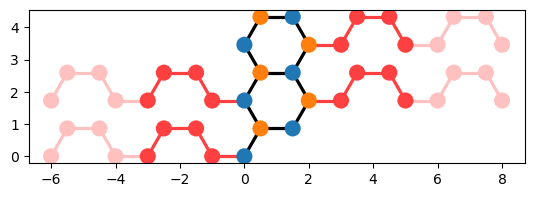

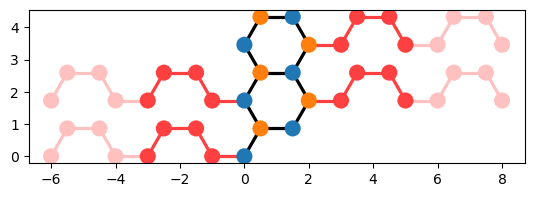

In [4]:
syst, left_lead, right_lead = make_system(
    scatter_width = 5, # For a simple molecule: 3
    scatter_length = 1, # For a simple molecule: 1
    lead_width = 2, # For a simple molecule: 2
    scatter_up_shift = 1, # For a simple molecule: 1
    left_lead_up_shift = 0, # 0
    right_lead_up_shift = 2, # 0
)

_, left_lead2, right_lead2 = make_system(
    scatter_width = 5, # For a simple molecule: 3
    scatter_length = 1, # For a simple molecule: 1
    lead_width = 2, # For a simple molecule: 2
    scatter_up_shift = 1, # For a simple molecule: 1
    left_lead_up_shift = 2, # 2 or 4
    right_lead_up_shift = 4, # 2 or 4
)

# Connect leads

syst.attach_lead(left_lead2.reversed()) # left, central
syst.attach_lead(left_lead.reversed()) # left, lower
syst.attach_lead(right_lead) # right, lower
syst.attach_lead(right_lead2) # right, central

kwant.plot(syst)

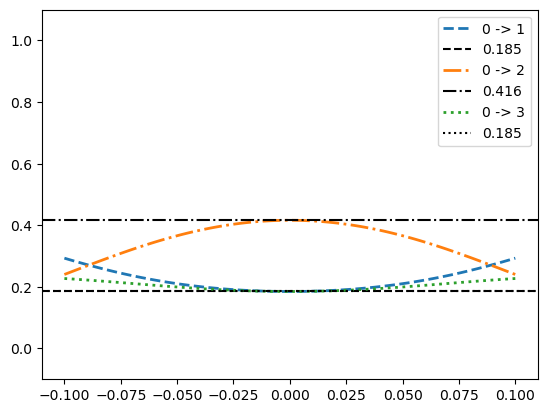

In [152]:
def map_range(x, x1, x2, y1, y2):
    return (x - x1) * (y2 - y1) / (x2 - x1) + y1
linestyles = ['-', '--', '-.', ':']
for i in [0]:
    for j in range(4):
        if i >= j: continue
        energies = np.linspace(-.1, .1, 100)
        conductance = np.array(compute_conductance(syst.finalized(), energies, 1, i, j))
        index = 4 * i + j
        plt.plot(
            energies,
            conductance,
            linestyle=linestyles[index % 4],
            linewidth=map_range(index, 0, 15, 2, 2),
            label=f"{i} -> {j}",
        )
        plt.axhline(
            conductance[len(energies)//2],
            color='black',
            linestyle=linestyles[index % 4],
            label=f"{conductance[len(energies)//2]:.3f}",
        )
plt.ylim(-.1, 1.1)
plt.legend()

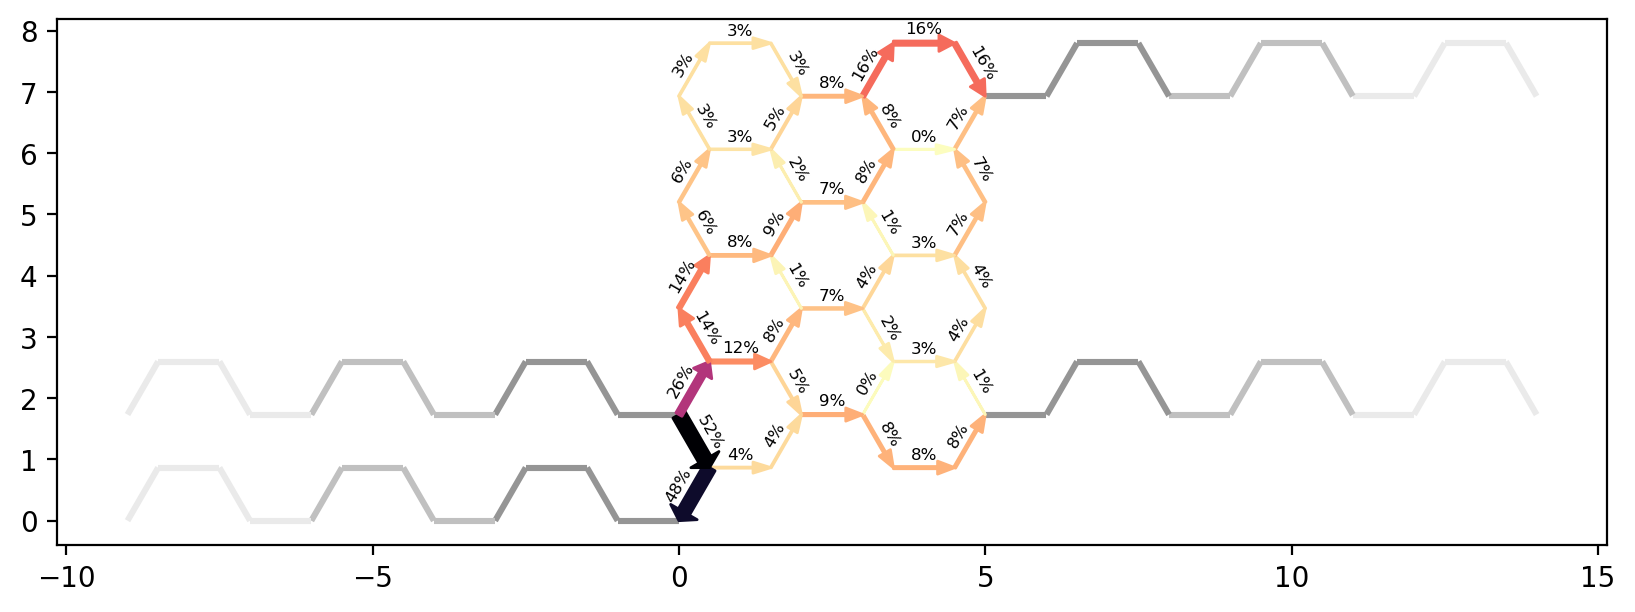

In [153]:
fsyst = syst.finalized()

current_intensity, num_channels, hoppings_coordinates, _, num_arrows = compute_current(fsyst, energy=0.5, t=1/2.75)

# normalized_current_intensity = np.array(current_intensity) # map_range(current_intensity, min(current_intensity), max(current_intensity), -1, 1)
normalized_current_intensity = map_range(np.abs(current_intensity), min(np.abs(current_intensity)), max(np.abs(current_intensity)), 0, 1)
normalized_current_intensity *= np.sign(current_intensity)

min_transmission_drawn = -0.1
dim = 30
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)

for j in range(num_arrows):
    if np.abs(normalized_current_intensity[j]) <= min_transmission_drawn: continue
    normvalue = (np.abs(normalized_current_intensity[j]))
    normvalue_min = (min(abs(normalized_current_intensity)))
    if normalized_current_intensity[j]<0:
        x1 = hoppings_coordinates[1][j][0]
        y1 = hoppings_coordinates[1][j][1]
        x2 = hoppings_coordinates[0][j][0]
        y2 = hoppings_coordinates[0][j][1]
    if normalized_current_intensity[j]>=0:
        x1 = hoppings_coordinates[0][j][0]
        y1 = hoppings_coordinates[0][j][1]
        x2 = hoppings_coordinates[1][j][0]
        y2 = hoppings_coordinates[1][j][1]
    thickness = map_range(normvalue, normvalue_min, 1, 0, 150) / dim
    ax.annotate(
        "",
        xy=(x1, y1),
        xytext=(x2, y2),
        arrowprops=dict(
            color=plt.cm.magma(map_range(normvalue, normvalue_min, 1, 1, 0)),
            headlength=map_range(normvalue, normvalue_min, 1, 200, 100) / dim,
            headwidth=map_range(normvalue, normvalue_min, 1, 100, 350) / dim,
            width=thickness, # switch to 40 if the arrows are too thick
        )
    )
    x = (x1 + x2) / 2
    y = (y1 + y2) / 2
    angle = math.atan2(y2 - y1, x2 - x1)
    angle = (angle * 180 / math.pi + 90) % 180 - 90
    plt.text(
        x=x - (0.2 + thickness / 50) * math.sin(angle * math.pi / 180),
        y=y + (0.2 + thickness / 50) * math.cos(angle * math.pi / 180),
        s=f"{abs(current_intensity[j]):.0%}",
        fontsize=6,
        color="black",
        horizontalalignment="center",
        verticalalignment="center",
        rotation=angle,
    )

kwant.plot(
    syst,
    num_lead_cells=3,
    site_size=0,
    hop_color="w",
    lead_site_size=0,
    lead_color="gray",
    ax=ax,
)
ax.set_aspect("equal")

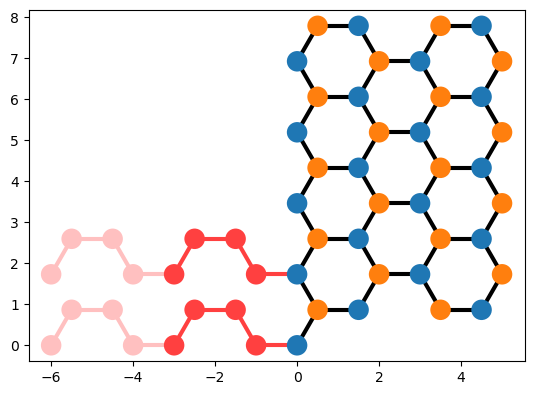

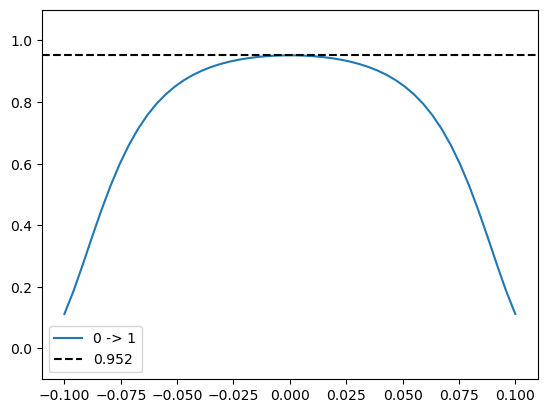

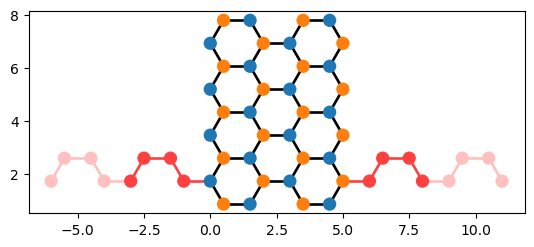

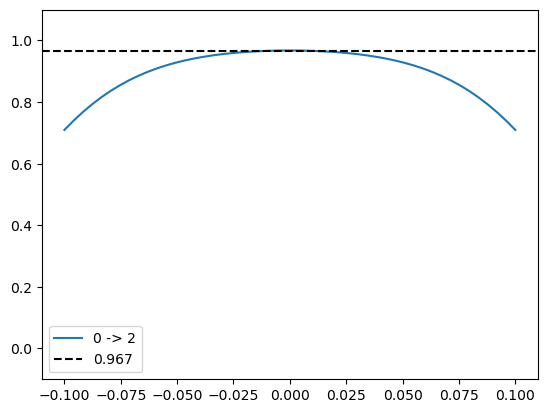

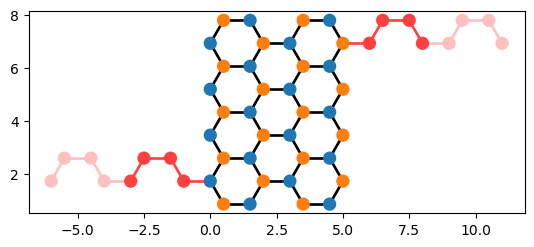

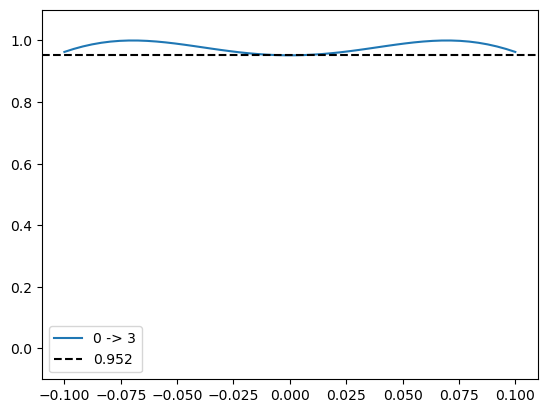

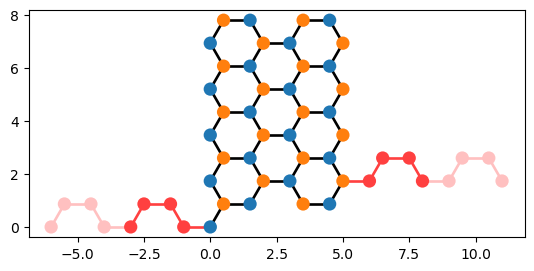

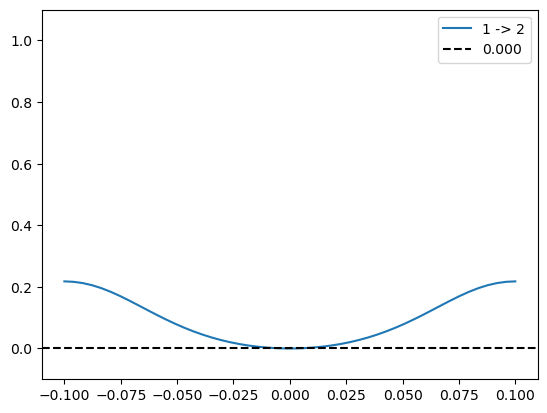

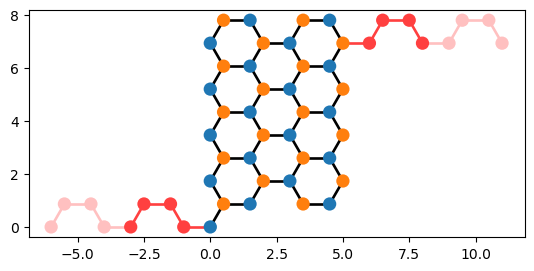

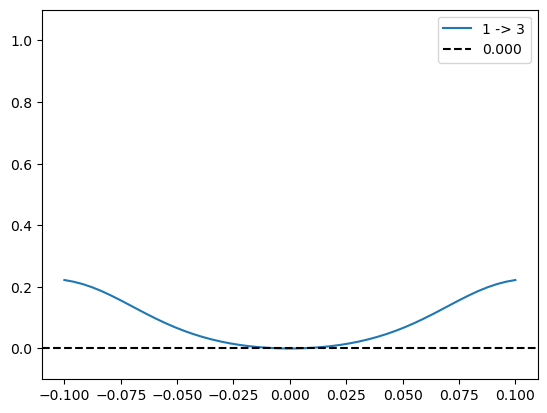

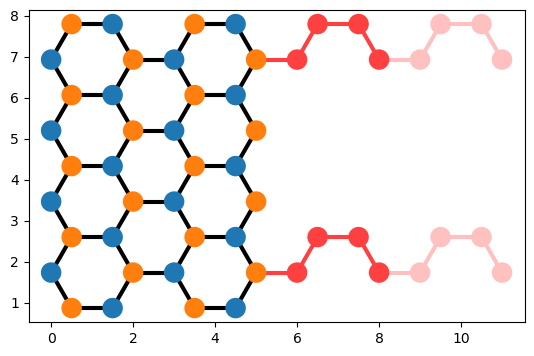

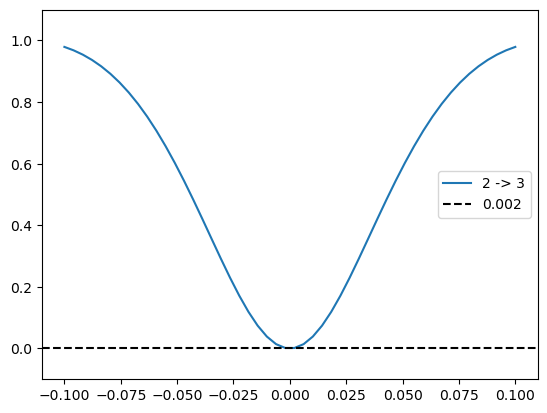

In [155]:
conds = np.zeros((4, 4))

for i in [0, 1, 2, 3]:
    for j in [0, 1, 2, 3]:
        if i >= j:
            continue
    
        syst0, left_lead, right_lead = make_system(
            scatter_width = 9, # For a simple molecule: 3
            scatter_length = 2, # For a simple molecule: 1
            lead_width = 2, # For a simple molecule: 2
            scatter_up_shift = 1, # For a simple molecule: 1
            left_lead_up_shift = 0, # 0
            right_lead_up_shift = 2, # 0
        )

        _, left_lead2, right_lead2 = make_system(
            scatter_width = 9, # For a simple molecule: 3
            scatter_length = 2, # For a simple molecule: 1
            lead_width = 2, # For a simple molecule: 2
            scatter_up_shift = 1, # For a simple molecule: 1
            left_lead_up_shift = 2, # 2
            right_lead_up_shift = 8, # 2
        )

        # Connect leads

        leads = [left_lead2.reversed(), left_lead.reversed(), right_lead, right_lead2]

        syst = syst0
        syst.attach_lead(leads[i])
        syst.attach_lead(leads[j])
        kwant.plot(syst)

        # Compute conductances

        energies = np.linspace(-.1, .1, 50)
        conductance = np.array(compute_conductance(syst.finalized(), energies, 1, 0, 1))
        plt.plot(
            energies,
            conductance,
            label=f"{i} -> {j}",
        )
        cond = conductance[50//2]
        conds[i, j] = cond
        plt.axhline(
            conductance[50//2],
            color='black',
            linestyle='--',
            label=f"{cond:.3f}",
        )
        plt.ylim(-.1, 1.1)
        plt.legend()